The Least Squares Generative Adversarial Network, or LSGAN for short, is an extension to the GAN architecture proposed by Xudong Mao, et al. in their 2016 paper titled **“Least Squares Generative Adversarial Networks."** The LSGAN is a modification to the GAN architecture that changes the loss function for the discriminator from binary cross entropy to a least squares loss.

The motivation for this change is that the least squares loss will penalize generated images based on their distance from the decision boundary. This will provide a strong gradient signal for generated images that are very different or far from the existing data and address the problem of saturated loss.

In addition to avoiding loss saturation, the LSGAN also results in a more stable training process and the generation of higher quality and larger images than the traditional deep convolutional GAN.

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from matplotlib import pyplot as plt

"minimizing the objective function of regular GAN suffers from vanishing gradients, which makes it hard to update the generator. LSGANs can relieve this problem because LSGANs penalize samples based on their distances to the decision boundary, which generates more gradients to update the generator."

— Least Squares Generative Adversarial Networks, 2016.

In [25]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='linear', kernel_initializer=init))
    # compile model with L2 loss
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

The model is optimized using the mean squared error (MSE) loss function as per the LSGAN.===>loss='mse'. <br>
The generator model takes a point in latent space as input and outputs a grayscale image with the shape 28×28 pixels, where pixel values are in the range [-1,1] via the tanh activation function on the output layer.

In [26]:
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 256 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Reshape((7, 7, 256)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# upsample to 28x28
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), padding='same', kernel_initializer=init))
	model.add(Activation('tanh'))
	return model

In [27]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	for layer in discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
	return model

The generator model is updated via the discriminator model. This is achieved by creating a composite model that stacks the generator on top of the discriminator so that error signals can flow back through the discriminator to the generator.

The weights of the discriminator are marked as not trainable when used in this composite model. Updates via the composite model involve using the generator to create new images by providing random points in the latent space as input. The generated images are passed to the discriminator, which will classify them as real or fake. The weights are updated as though the generated images are real (e.g. target of 1.0), allowing the generator to be updated toward generating more realistic images.

Define a function to load the MNIST handwritten digit dataset and scale the pixel values to the range [-1,1] to match the images output by the generator model.

In [28]:
# load mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [29]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [30]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [31]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [33]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
      # define subplot
      plt.subplot(10, 10, 1 + i)
      # turn off axis
      plt.axis('off')
      # plot raw pixel data
      plt.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    #filename1 = 'generated_plot_%06d.png' % (step+1)
    #plt.savefig(filename1)
    #plt.close()
    plt.show()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    #print('Saved %s and %s' % (filename1, filename2))
    print('Saved %s' % (filename2))

In [34]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    plt.plot(d1_hist, label='Discriminator Real data loss1')
    plt.plot(d2_hist, label='Discriminator Fake data loss2')
    plt.plot(g_hist, label='gloss')
    plt.legend()
    #filename = 'plot_line_plot_loss.png'
    #plt.savefig(filename)
    #plt.close()
    #print('Saved %s' % (filename))
    plt.show()

In [36]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=128):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for storing loss, for plotting later
	d1_hist, d2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
		# record history
		d1_hist.append(d_loss1)
		d2_hist.append(d_loss2)
		g_hist.append(g_loss)
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 1) == 0:
			  summarize_performance(i, g_model, latent_dim)
	# create line plot of training history
	plot_history(d1_hist, d2_hist, g_hist)
 

(60000, 28, 28, 1)
>1, d1=1.053, d2=0.184 g=2.254
>2, d1=2.696, d2=0.210 g=0.946
>3, d1=2.857, d2=0.384 g=0.651
>4, d1=0.582, d2=0.130 g=0.550
>5, d1=0.329, d2=0.088 g=0.670
>6, d1=0.464, d2=0.104 g=0.587
>7, d1=0.374, d2=0.120 g=0.421
>8, d1=0.169, d2=0.120 g=0.413
>9, d1=0.352, d2=0.110 g=0.356
>10, d1=0.278, d2=0.082 g=0.455
>11, d1=0.240, d2=0.078 g=0.348
>12, d1=0.345, d2=0.084 g=0.309
>13, d1=0.283, d2=0.108 g=0.352
>14, d1=0.293, d2=0.141 g=0.623
>15, d1=0.220, d2=0.204 g=0.355
>16, d1=0.312, d2=0.483 g=0.973
>17, d1=0.511, d2=0.494 g=0.392
>18, d1=0.843, d2=0.826 g=0.714
>19, d1=0.825, d2=0.352 g=0.303
>20, d1=0.553, d2=1.022 g=1.435
>21, d1=0.314, d2=0.134 g=1.961
>22, d1=0.244, d2=0.454 g=5.964
>23, d1=0.210, d2=0.327 g=0.554
>24, d1=0.314, d2=2.926 g=6.240
>25, d1=0.136, d2=1.359 g=0.381
>26, d1=0.223, d2=4.658 g=1.768
>27, d1=0.544, d2=3.246 g=2.238
>28, d1=0.521, d2=3.414 g=1.503
>29, d1=0.315, d2=1.804 g=0.338
>30, d1=0.199, d2=0.993 g=0.261
>31, d1=0.142, d2=0.383 g=0.27

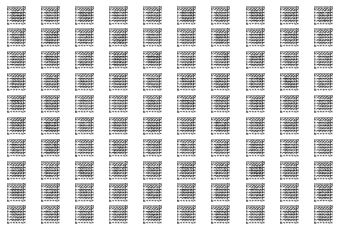

Saved model_000468.h5
>469, d1=0.028, d2=0.026 g=0.128
>470, d1=0.032, d2=0.022 g=0.122
>471, d1=0.053, d2=0.035 g=0.196
>472, d1=0.023, d2=0.047 g=0.069
>473, d1=0.039, d2=0.098 g=0.253
>474, d1=0.035, d2=0.161 g=0.023
>475, d1=0.039, d2=0.293 g=0.403
>476, d1=0.062, d2=0.401 g=0.024
>477, d1=0.051, d2=0.692 g=0.622
>478, d1=0.042, d2=0.990 g=0.043
>479, d1=0.043, d2=1.483 g=0.793
>480, d1=0.047, d2=1.825 g=0.035
>481, d1=0.047, d2=1.778 g=0.542
>482, d1=0.070, d2=1.324 g=0.041
>483, d1=0.032, d2=0.843 g=0.211
>484, d1=0.024, d2=0.482 g=0.067
>485, d1=0.031, d2=0.343 g=0.232
>486, d1=0.030, d2=0.182 g=0.102
>487, d1=0.037, d2=0.081 g=0.103
>488, d1=0.040, d2=0.023 g=0.135
>489, d1=0.030, d2=0.023 g=0.106
>490, d1=0.047, d2=0.022 g=0.130
>491, d1=0.034, d2=0.032 g=0.164
>492, d1=0.025, d2=0.028 g=0.121
>493, d1=0.036, d2=0.041 g=0.209
>494, d1=0.033, d2=0.035 g=0.152
>495, d1=0.039, d2=0.042 g=0.172
>496, d1=0.023, d2=0.026 g=0.146
>497, d1=0.036, d2=0.053 g=0.317
>498, d1=0.040, d2=0.

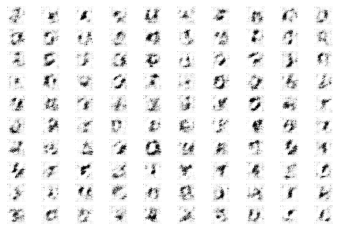

Saved model_000936.h5
>937, d1=0.051, d2=0.046 g=0.052
>938, d1=0.053, d2=0.057 g=0.035
>939, d1=0.033, d2=0.087 g=0.057
>940, d1=0.085, d2=0.022 g=0.033
>941, d1=0.034, d2=0.041 g=0.051
>942, d1=0.043, d2=0.027 g=0.061
>943, d1=0.044, d2=0.020 g=0.035
>944, d1=0.048, d2=0.047 g=0.036
>945, d1=0.044, d2=0.033 g=0.034
>946, d1=0.037, d2=0.026 g=0.040
>947, d1=0.035, d2=0.042 g=0.042
>948, d1=0.035, d2=0.023 g=0.057
>949, d1=0.045, d2=0.069 g=0.057
>950, d1=0.055, d2=0.025 g=0.036
>951, d1=0.037, d2=0.038 g=0.066
>952, d1=0.045, d2=0.041 g=0.072
>953, d1=0.055, d2=0.062 g=0.070
>954, d1=0.048, d2=0.032 g=0.056
>955, d1=0.057, d2=0.087 g=0.074
>956, d1=0.063, d2=0.055 g=0.115
>957, d1=0.094, d2=0.035 g=0.060
>958, d1=0.142, d2=0.178 g=0.045
>959, d1=0.064, d2=0.024 g=0.060
>960, d1=0.046, d2=0.033 g=0.087
>961, d1=0.062, d2=0.047 g=0.057
>962, d1=0.039, d2=0.056 g=0.077
>963, d1=0.071, d2=0.063 g=0.036
>964, d1=0.037, d2=0.200 g=0.077
>965, d1=0.062, d2=0.038 g=0.101
>966, d1=0.100, d2=0.

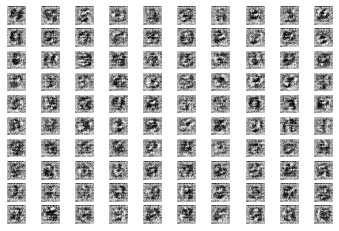

Saved model_001404.h5
>1405, d1=0.010, d2=0.044 g=0.042
>1406, d1=0.030, d2=0.028 g=0.037
>1407, d1=0.022, d2=0.021 g=0.020
>1408, d1=0.017, d2=0.020 g=0.028
>1409, d1=0.022, d2=0.025 g=0.021
>1410, d1=0.018, d2=0.027 g=0.023
>1411, d1=0.020, d2=0.033 g=0.029
>1412, d1=0.023, d2=0.020 g=0.035
>1413, d1=0.020, d2=0.025 g=0.034
>1414, d1=0.011, d2=0.019 g=0.037
>1415, d1=0.018, d2=0.036 g=0.032
>1416, d1=0.015, d2=0.023 g=0.053
>1417, d1=0.018, d2=0.031 g=0.033
>1418, d1=0.016, d2=0.040 g=0.067
>1419, d1=0.022, d2=0.033 g=0.049
>1420, d1=0.021, d2=0.022 g=0.047
>1421, d1=0.019, d2=0.026 g=0.062
>1422, d1=0.016, d2=0.032 g=0.024
>1423, d1=0.029, d2=0.037 g=0.085
>1424, d1=0.033, d2=0.031 g=0.083
>1425, d1=0.016, d2=0.023 g=0.027
>1426, d1=0.037, d2=0.039 g=0.027
>1427, d1=0.014, d2=0.031 g=0.033
>1428, d1=0.028, d2=0.030 g=0.043
>1429, d1=0.018, d2=0.022 g=0.036
>1430, d1=0.013, d2=0.028 g=0.039
>1431, d1=0.024, d2=0.026 g=0.028
>1432, d1=0.020, d2=0.029 g=0.028
>1433, d1=0.020, d2=0.044 

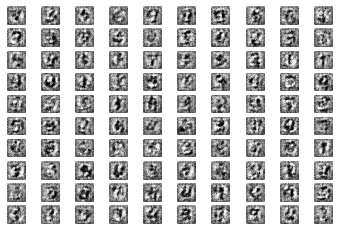

Saved model_001872.h5
>1873, d1=0.026, d2=0.024 g=0.030
>1874, d1=0.012, d2=0.023 g=0.032
>1875, d1=0.019, d2=0.034 g=0.029
>1876, d1=0.012, d2=0.031 g=0.039
>1877, d1=0.024, d2=0.040 g=0.047
>1878, d1=0.016, d2=0.035 g=0.088
>1879, d1=0.017, d2=0.034 g=0.061
>1880, d1=0.021, d2=0.032 g=0.064
>1881, d1=0.022, d2=0.038 g=0.031
>1882, d1=0.016, d2=0.025 g=0.029
>1883, d1=0.016, d2=0.030 g=0.035
>1884, d1=0.011, d2=0.029 g=0.030
>1885, d1=0.012, d2=0.032 g=0.033
>1886, d1=0.014, d2=0.031 g=0.030
>1887, d1=0.015, d2=0.053 g=0.045
>1888, d1=0.012, d2=0.033 g=0.041
>1889, d1=0.013, d2=0.031 g=0.041
>1890, d1=0.017, d2=0.038 g=0.027
>1891, d1=0.011, d2=0.033 g=0.049
>1892, d1=0.013, d2=0.030 g=0.052
>1893, d1=0.008, d2=0.044 g=0.034
>1894, d1=0.016, d2=0.077 g=0.039
>1895, d1=0.031, d2=0.036 g=0.039
>1896, d1=0.018, d2=0.044 g=0.038
>1897, d1=0.015, d2=0.035 g=0.035
>1898, d1=0.010, d2=0.038 g=0.021
>1899, d1=0.020, d2=0.043 g=0.031
>1900, d1=0.013, d2=0.031 g=0.049
>1901, d1=0.016, d2=0.038 

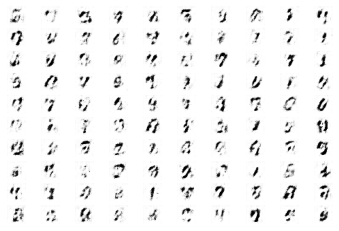

Saved model_002340.h5


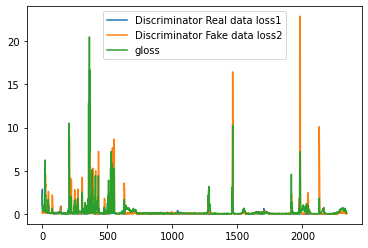

In [37]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

### How to Generate Images With LSGAN

In [38]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

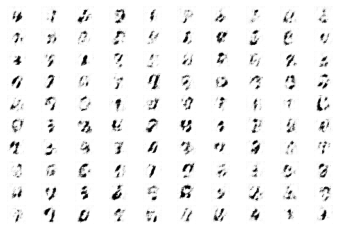

In [40]:
# create a plot of generated images (reversed grayscale)
def plot_generated(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
# load model
model = load_model('model_002340.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
plot_generated(X, 10)